# Предсказание цены квартиры

## Введение

Импортируем необходимые библиотеки и датасет

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [3]:
import warnings 
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv(r"D:\Портфолио\MachineLearning\FlatsInMoscow\data\flats_moscow.csv")

 Описание признаков

price: цена квартиры в \$1000

totsp: общая площадь квартиры, кв.м.

livesp: жилая площадь квартиры, кв.м.

kitsp: площадь кухни, кв.м.

dist: расстояние от центра в км.

metrdist: расстояние до метро в минутах

walk: 1 – пешком от метро, 0 – на транспорте

brick: 1 – кирпичный, монолит ж/б, 0 – другой

floor: 1 – этаж кроме первого и последнего, 0 – иначе

code: число от 1 до 8, обозначающее район города

    1. Север, около Калужско-Рижской линии метро
    2. Север, около Серпуховско-Тимирязевской линии метро
    3. Северо-запад, около Замоскворецкой линиии метро
    4. Северо-запад, около Таганско-Краснопресненской линиии метро
    5. Юго-восток, около Люблинской линиии метро
    6. Юго-восток, около Таганско-Краснопресненской линиии метро
    7. Восток, около Калининской линиии метро
    8. Восток, около Арбатско-Покровской линиии метро

In [5]:
df.head()

,Unnamed: 0,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
0,1,81,58,40,6.0,12.5,7,1,1,1,3
1,2,75,44,28,6.0,13.5,7,1,0,1,6
2,3,128,70,42,6.0,14.5,3,1,1,1,3
3,4,95,61,37,6.0,13.5,7,1,0,1,1
4,5,330,104,60,11.0,10.5,7,0,1,1,3


Посмотрим типы признаков

In [6]:
df.dtypes

Unnamed: 0      int64
price           int64
totsp           int64
livesp          int64
kitsp         float64
dist          float64
metrdist        int64
walk            int64
brick           int64
floor           int64
code            int64
dtype: object

Проверим данные на наличие пропусков

In [7]:
df.isna().sum()

Unnamed: 0    0
price         0
totsp         0
livesp        0
kitsp         0
dist          0
metrdist      0
walk          0
brick         0
floor         0
code          0
dtype: int64

Во всех признаках нет na-значений и все они имеют числовой тип

Посмотрим сколько уникальных значений в столбцах

In [8]:
df.nunique()

Unnamed: 0    2040
price          180
totsp           91
livesp          58
kitsp           22
dist            22
metrdist        14
walk             2
brick            2
floor            2
code             8
dtype: int64

Удалим уникальный столбец

In [9]:
df.drop("Unnamed: 0", axis=1, inplace=True)

## Базовая модель

In [162]:
train = df.drop('price', axis=1)
test = df.price

In [165]:
X_train, X_test, y_train, y_test = train_test_split(train, test, test_size=0.3, random_state=0)

In [166]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.6522764714461098

## Очистка данных

### Проверим данные на наличие полных дубликатов

In [10]:
df[df.duplicated()].shape

(43, 10)

В нашей выборке присутствует 43 дубликата, удалим их

In [11]:
df = df.drop_duplicates().reset_index(drop=True)

### Посмотрим как цена зависит от code(район города)

In [14]:
df.groupby(df['code'])['price'].mean()

code
1    134.376384
2    110.153110
3    148.313783
4    148.305419
5    115.981651
6    110.610442
7    114.684932
8    137.140449
Name: price, dtype: float64

In [15]:
df.groupby(df['code'])['price'].max()

code
1    420
2    299
3    530
4    730
5    410
6    240
7    350
8    450
Name: price, dtype: int64

Как мы можем заметить, квартиры из районов 3 и 4, имеют самую большую цену, в то время как квартиры из районов 2 и 6 имеют самую низкую стоимость

### Посмотрим как цена зависит от floor(этаж)

In [16]:
df.groupby(df['floor'])['price'].mean()

floor
0    114.688995
1    131.205826
Name: price, dtype: float64

In [17]:
df.groupby(df['floor'])['price'].max()

floor
0    350
1    730
Name: price, dtype: int64

Можем заметить, что средняя цена за квартиры, которые продаются на первом или последнем этаже, не сильно отличается от тех, что продаются на других этажах

Но  можно заметить, что максимальные цены в двух группах довольно сильно различаются

### Посмотрим как цена зависит от brick(материал дома)

In [18]:
df.groupby(df['brick'])['price'].mean()

brick
0    118.236823
1    147.460000
Name: price, dtype: float64

In [19]:
df.groupby(df['floor'])['price'].max()

floor
0    350
1    730
Name: price, dtype: int64

Как и с предыдущим признаком, особых различий в среднем не наблюдается, а вот в максимальных значениях есть существенная разница

### Посмотрим распределение целевой переменной

Text(0, 0.5, 'Количество квартир')

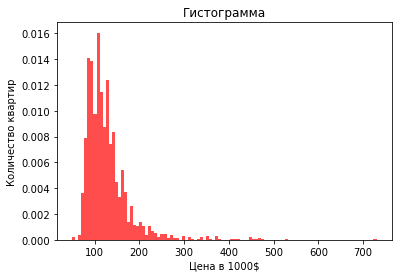

In [20]:
plt.hist(df.price, color='red', density=True, alpha=0.7, bins=100);

plt.title('Гистограмма')
plt.xlabel('Цена в 1000$')
plt.ylabel('Количество квартир')

На графике видная явная ассиметрия и заметны выбросы

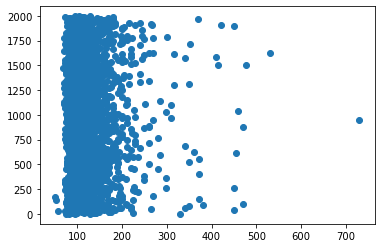

In [21]:
plt.scatter(x=df.price, y=np.arange(len(df)))

Посмотрим взаимосвязь price и totsp

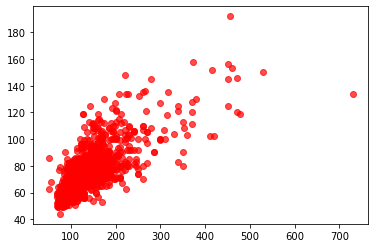

In [22]:
plt.scatter(df.price, y=df.totsp, c='red', alpha=0.7)

Можно заметить явные выбросы

Рассмотрим квартиру, которая находится дальше остальных

In [23]:
df[df.price == df.price.max()]

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
953,730,134,102,10.0,9.0,10,1,1,1,4


Сравним эту квартиру с остальными квартирами, которые имеют примерно схожие параметры

In [24]:
df.sort_values(by='price', ascending=False).head(10)

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
953,730,134,102,10.0,9.0,10,1,1,1,4
1625,530,150,80,15.0,7.5,7,1,1,1,3
1500,477,119,93,15.0,9.0,1,1,0,1,3
101,470,120,75,18.0,9.0,10,1,1,1,3
875,470,146,86,16.0,14.5,5,1,1,1,3
1041,460,153,84,18.0,9.0,5,1,1,1,4
620,455,192,92,18.0,7.5,5,1,0,1,3
1895,451,156,80,20.0,10.5,5,0,1,1,3
263,450,145,82,14.0,4.5,3,1,1,1,8
35,450,125,80,20.0,9.0,3,1,0,1,4


Как мы можем заметить, по некоторым признакам эта квартира уступает другим, более дешевым


Возможно дело в том, что у неё самая большая жилая площадь

In [25]:
df.sort_values(by='livesp', ascending=False).head()

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
953,730,134,102,10.0,9.0,10,1,1,1,4
1500,477,119,93,15.0,9.0,1,1,0,1,3
620,455,192,92,18.0,7.5,5,1,0,1,3
1920,265,136,88,14.0,10.5,10,1,1,1,3
875,470,146,86,16.0,14.5,5,1,1,1,3


Да, у неё действительно самая большая жилая площадь

Попробуем её удалить, потому что по остальным характеристикам она уступает более дешевым квартирам

In [26]:
df_without_max_price_flat = df.drop(953)

Остальные квартиры не выделяются завышенными ценами

Проверим квартиры по остальными признакам

### Проверим на аномалии столбец totsp(общая площадь)

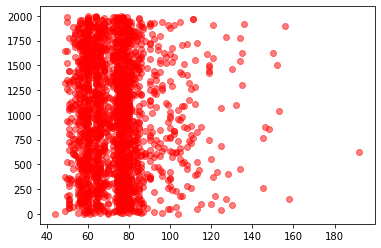

In [27]:
plt.scatter(x=df_without_max_price_flat.totsp, y=np.arange(len(df_without_max_price_flat)), c='red', alpha=0.5)

На графике видны явные аномалии

Отсортируем квартиры по размеру площади и сравним с ценой за квартиру

In [28]:
df_without_max_price_flat.sort_values(by='totsp', ascending=False).head(10)

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
620,455,192,92,18.0,7.5,5,1,0,1,3
150,372,158,80,20.0,10.5,10,1,0,1,3
1895,451,156,80,20.0,10.5,5,0,1,1,3
1041,460,153,84,18.0,9.0,5,1,1,1,4
1505,415,152,80,17.0,3.0,5,1,0,1,1
1625,530,150,80,15.0,7.5,7,1,1,1,3
862,220,148,85,14.0,14.5,7,0,1,1,3
875,470,146,86,16.0,14.5,5,1,1,1,3
763,280,145,66,16.0,12.7,3,1,0,0,5
263,450,145,82,14.0,4.5,3,1,1,1,8


Как мы видим, у этой квартиры не самый высокий ценник, хотя у неё самая большая площадь

По остальным характеристикам она не сильно отличается от похожих квартир

Удалим эту квартиру

In [29]:
df_without_max_price_flat_totsp = df_without_max_price_flat.drop(620)

### Проверим на аномалии столбец livesp (жилая площадь)

Посмотрим взаимосвязь totsp и livesp

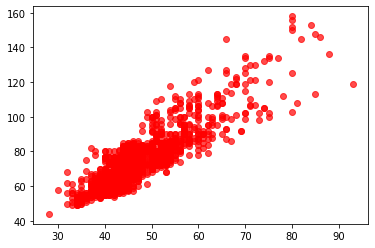

In [128]:
plt.scatter(df_without_max_price_flat_totsp.livesp, y=df_without_max_price_flat_totsp.totsp, c='red', alpha=0.7);

Как мы видим, столбцы livesp(жилая площадь) и totsp(общая площадь) квартиры имеют сильную корреляцию 

Нельзя однозначно сказать, что есть аномалии

### Проверим на аномалии столбец kitsp (площадь кухни)

Посмотрим распределение этого столбца

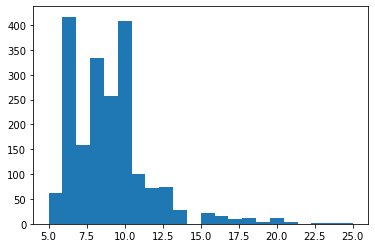

In [31]:
plt.hist(df_without_max_price_flat_totsp.kitsp, bins=len(df_without_max_price_flat_totsp.kitsp.unique()));

На графике видны квартиры, у которых большая площадь кухни, возможно у этих квартир большая общая площадь

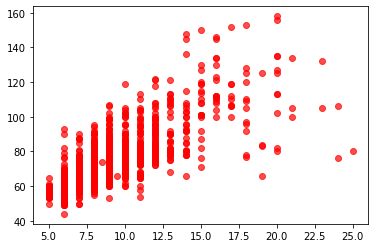

In [32]:
plt.scatter(df_without_max_price_flat_totsp.kitsp, y=df_without_max_price_flat_totsp.totsp, c='red', alpha=0.7)

Заметны выбросы (квартиры у которых большая площадь кухни, но маленькая площадь всей квартиры)

Отсортируем квартиры по площади кухни

In [33]:
df_without_max_price_flat_totsp.sort_values(by='kitsp', ascending=False).head(10)

,price,totsp,livesp,kitsp,dist,metrdist,walk,brick,floor,code
1112,153,80,40,25.0,10.5,10,0,0,1,3
517,190,106,58,24.0,9.0,5,0,0,1,4
1653,145,76,44,24.0,12.7,2,1,0,0,5
1105,252,132,74,23.0,12.5,3,1,1,0,3
663,240,105,55,23.0,10.0,5,1,0,1,6
1934,135,105,58,21.0,13.5,15,1,1,1,1
777,200,100,66,21.0,9.0,15,1,1,1,3
1544,207,134,77,21.0,15.5,5,1,0,1,1
1299,317,135,70,20.0,9.0,2,1,0,1,3
527,350,113,85,20.0,9.0,10,1,0,1,3


Можно заметить две квартиры, площади которых ниже остальных квартир, но площади кухонь у них больше других

Удалим эти квартиры

In [59]:
df_clean = df_without_max_price_flat_totsp.drop([1112, 1653])

Построим таблицу корреляции

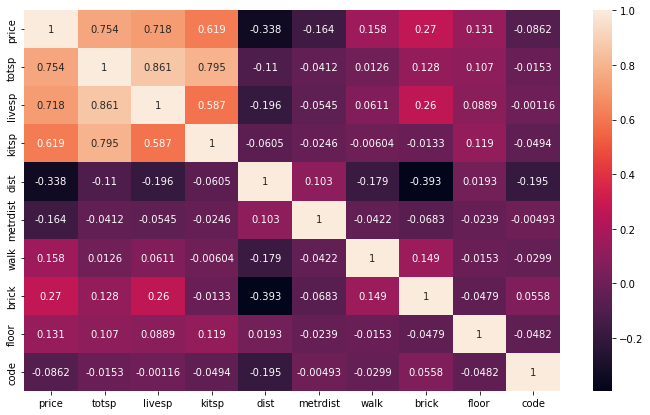

In [35]:
plt.subplots(figsize=(12, 7))
sns.heatmap(df_clean.corr(), annot=True, fmt='.3g');

Как мы можем заметить, некоторые признаки( totsp, live, kitsp) имеют сильную корреляцию с целевым признаком. 

Однако эти признаки имеют сильную корреляцию между собой. 

Можно заметить отрицательную корреляцию между признаками (dist и price) и (brick и dist).

<AxesSubplot:xlabel='dist', ylabel='price'>

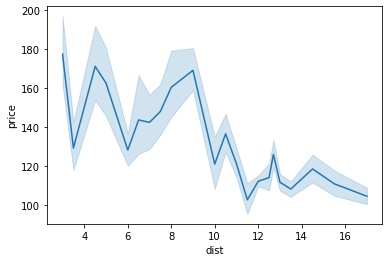

In [108]:
sns.lineplot(data=df_clean, x='dist', y='price')

На графике видно, что с увеличением расстояния от центра метро цена квартиры падает, хотя также видны скачки 

## Построение моделей

### Построение моделей без параметров

In [167]:
train = df_clean.drop('price', axis=1)
test = df_clean.price

In [168]:
X_train, X_test, y_train, y_test = train_test_split(train,test, test_size=0.3, random_state=0)

#### Ridge

In [169]:
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.7164216771955073

#### KNeighborsRegressor

In [175]:
model = KNeighborsRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.7032106926451407

#### RandomForestRegressor

In [174]:
model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2_score(y_test, y_pred)

0.7756632860847967

Как мы можем заметить, лучше всего отработала модель RandomForestRegressor, Ridge показала хуже результат на 6%, а KNeighborsRegressor на 7% хуже.

Подберем для моделей Ridge и RandomForestRegressor гиперпараметры.

### Построение моделей с гиперпараметрами

#### Ridge

In [187]:
ridge_params = {'alpha': [0, 1],
               'fit_intercept': [False, True],
               'max_iter': [1000, 2000, 3000]}

ridge = Ridge()

clf = GridSearchCV(ridge, ridge_params, cv=5)

In [188]:
best_model = clf.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

r2_score(y_test, y_pred)

0.7164216771955073

Гиперпараметры никак не повлияли на результат предсказания

До: 0.7164

После: 0.7164

#### RandomForestRegressor

In [191]:
forest_params = {'n_estimators': [100, 300],
                'criterion': ['squared_error', 'absolute_error'],
                'max_depth': [None, 3]}

forest = RandomForestRegressor()

clf = GridSearchCV(forest, forest_params, cv=5)

In [192]:
best_model = clf.fit(X_train, y_train)

In [193]:
y_pred = best_model.predict(X_test)
r2_score(y_test, y_pred)

0.7767987865925903

После подбора гиперпараметров, можно заметить, что результат предсказания почти не изменился

До: 0.7756

После: 0.7767